## Домашняя работа 4. 

Максимальный балл за задание - 10.

## Данные


В этой домашней работе мы будем обучать модели машинного обучения, ставить эксперименты, подбирать гиперпараметры, сравнивать и смешивать модели. Вам предлагается решить задачу бинарной классификации, а именно построить алгоритм, определяющий превысит ли средний заработок человека порог $50k. Каждый объект выборки — человек, для которого известны следующие признаки:
 - age
 - workclass
 - fnlwgt
 - education
 - education-num
 - marital-status
 - occupation
 - relationship
 - race
 - sex
 - capital-gain
 - capital-loss
 - hours-per-week
 
Более подробно про признаки можно почитать [здесь](http://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.names). Целевой признак записан в переменной *>50K,<=50K*.

## Метрика качества

В задании мы будем оценивать качество моделей с помощью метрики AUC-ROC.

## Подбор гиперпараметров модели

В задачах машинного обучения следует различать параметры модели и гиперпараметры (структурные параметры). Обычно параметры модели настраиваются в ходе обучения (например, веса в линейной модели или структура решающего дерева), в то время как гиперпараметры задаются заранее (например, регуляризация в линейной модели или максимальная глубина решающего дерева). Каждая модель обычно имеет множество гиперпараметров, и нет универсальных наборов гиперпараметров, оптимально работающих во всех задачах, для каждой задачи нужно подбирать свой набор.

Для оптимизации гиперпараметров модели часто используют _перебор по сетке (grid search)_: для каждого гиперпараметра выбирается несколько значений, перебираются все комбинации значений и выбирается комбинация, на которой модель показывает лучшее качество (с точки зрения метрики, которая оптимизируется). Однако в этом случае нужно грамотно оценивать построенную модель, а именно делать разбиение на обучающую и тестовую выборку. Есть несколько схем, как это можно реализовать: 

 - Разбить имеющуюся выборку на обучающую и тестовую. В этом случае сравнение большого числа моделей при переборе параметров приводит к ситуации, когда лучшая на тестовой подвыборке модель не сохраняет свои качества на новых данных. Можно сказать, что происходит _переобучение_ на тестовую выборку.
 - Для устранения описанной выше проблемы, можно разбить данные на 3 непересекающихся подвыборки: обучение (`train`), валидация (`validation`) и контроль (`test`). Валидационную подвыборку используют для сравнения моделей, а `test` — для окончательной оценки качества и сравнения семейств моделей с подобранными параметрами.
 - Другой способ сравнения моделей — [кросс-валидация](http://en.wikipedia.org/wiki/Cross-validation_(statistics). Существуют различные схемы кросс-валидации:
  - Leave-One-Out
  - K-Fold
  - Многократное случайное разбиение выборки
  
Кросс-валидация вычислительно затратна, особенно если вы делаете перебор по сетке с очень большим числом комбинации. С учетом конечности времени на выполнение задания, возникает ряд компромиссов: 
  - сетку можно делать более разреженной, перебирая меньше значений каждого параметра; однако, надо не забывать, что в таком случае можно пропустить хорошую комбинацию параметров;
  - кросс-валидацию можно делать с меньшим числом разбиений или фолдов, но в таком случае оценка качества кросс-валидации становится более шумной и увеличивается риск выбрать неоптимальный набор параметров из-за случайности разбиения;
  - параметры можно оптимизировать последовательно (жадно) — один за другим, а не перебирать все комбинации; такая стратегия не всегда приводит к оптимальному набору;
  - перебирать не все комбинации параметров, а небольшое число случайно выбранных.

## Задание 

Загрузите набор данных *data.adult.csv*. Чтобы лучше понимать, с чем вы работаете/корректно ли вы загрузили данные можно вывести несколько первых строк на экран.

In [1]:
import pandas as pd
import numpy as np
import sklearn
import warnings
warnings.simplefilter("ignore")

In [2]:
df = pd.read_csv('data.adult.csv')
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
7,18,?,423460,11th,7,Never-married,?,Own-child,White,Male,0,0,36,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K


In [3]:
df.shape

(16280, 14)

Иногда в данных встречаются пропуски. Как задаются пропуски обычно либо прописывается в описании к данным, либо просто на месте пропуска после чтения данных оказывается значение numpy.nan. Более подробно о работе с пропусками в Pandas можно прочитать например [здесь](http://pandas.pydata.org/pandas-docs/stable/missing_data.html). 

В данном датасете пропущенные значения обозначены как "?". 

**Задание 1 (0.5 балла)** Найдите все признаки, имеющие пропущенные значения. Удалите из выборки все объекты с пропусками.

In [4]:
df = df.replace('?', np.nan)
df = df.dropna()
df.head(10)

,age,workclass,fnlwgt,education,education-num,marital-status,occupation,relationship,race,sex,capital-gain,capital-loss,hours-per-week,">50K,<=50K"
0,34,Local-gov,284843,HS-grad,9,Never-married,Farming-fishing,Not-in-family,Black,Male,594,0,60,<=50K
1,40,Private,190290,Some-college,10,Divorced,Sales,Not-in-family,White,Male,0,0,40,<=50K
2,36,Local-gov,177858,Bachelors,13,Married-civ-spouse,Prof-specialty,Own-child,White,Male,0,0,40,<=50K
3,22,Private,184756,Some-college,10,Never-married,Sales,Own-child,White,Female,0,0,30,<=50K
4,47,Private,149700,Bachelors,13,Married-civ-spouse,Tech-support,Husband,White,Male,15024,0,40,>50K
5,18,Private,446771,Some-college,10,Never-married,Adm-clerical,Own-child,White,Male,0,0,25,<=50K
6,31,Federal-gov,108464,Assoc-acdm,12,Married-civ-spouse,Tech-support,Husband,White,Male,0,0,40,<=50K
8,25,Private,110138,HS-grad,9,Never-married,Other-service,Not-in-family,White,Male,0,0,40,<=50K
9,53,Federal-gov,167410,Bachelors,13,Divorced,Tech-support,Not-in-family,Amer-Indian-Eskimo,Male,0,0,40,<=50K
10,19,Private,131615,HS-grad,9,Never-married,Machine-op-inspct,Own-child,White,Male,0,0,40,<=50K


In [5]:
df.shape

(15347, 14)

Обычно после загрузки датасета всегда необходима его некоторая предобработка. В данном случае она будет заключаться в следующем: 

 - Выделите целевую переменную в отдельную переменную, удалите ее из датасета и преобразуйте к бинарному формату.
 - Обратите внимание, что не все признаки являются вещественными. В начале мы будем работать только с вещественными признаками. Выделите их отдельно.

In [6]:
y = df['>50K,<=50K']
X = df.drop('>50K,<=50K', axis=1)
y

0        <=50K
1        <=50K
2        <=50K
3        <=50K
4         >50K
         ...  
16275    <=50K
16276     >50K
16277    <=50K
16278    <=50K
16279     >50K
Name: >50K,<=50K, Length: 15347, dtype: object

In [7]:
y = y.replace({'<=50K': 0,
              '>50K': 1})
y

0        0
1        0
2        0
3        0
4        1
        ..
16275    0
16276    1
16277    0
16278    0
16279    1
Name: >50K,<=50K, Length: 15347, dtype: int64

## Обучение классификаторов на вещественных признаках

В данном разделе необходимо будет работать только с вещественными признаками и целевой переменной.

В начале посмотрим как работает подбор параметров по сетке и как влияет на качество разбиение выборки. Сейчас и далее будем рассматривать 5 алгоритмов:
 - [kNN](http://scikit-learn.org/stable/modules/generated/sklearn.neighbors.KNeighborsClassifier.html)
 - [DecisonTree](http://scikit-learn.org/stable/modules/generated/sklearn.tree.DecisionTreeClassifier.html#sklearn.tree.DecisionTreeClassifier)
 - [SGD Linear Classifier](http://scikit-learn.org/stable/modules/generated/sklearn.linear_model.SGDClassifier.html)
 - [RandomForest](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)
 - [GradientBoosting](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingClassifier.html)

Для начала у первых трёх алгоритмов выберем один гиперпараметр, который будем оптимизировать:
 - kNN — число соседей (*n_neighbors*)
 - DecisonTree — глубина дерева (*max_depth*)
 - SGD Linear Classifier — оптимизируемая функция (*loss*)
 
Остальные параметры оставляйте в значениях по умолчанию. Для подбора гиперпараметров воспользуйтесь перебором по сетке, который реализован в классе [GridSearchCV](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.GridSearchCV.html). В качестве схемы кросс-валидации используйте 5-fold cv, которую можно задать с помощью класса [KFold](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.KFold.html).

**Задание 2 (1 балл)** Для каждого из первых трех алгоритмов подберите оптимальные значения указанных гиперпараметров. Для каждого из этих алгоритмов постройте график среднего качества по кросс-валидации при заданном значении гиперпараметра, на котором также отобразите доверительный интервал [m-std, m+std], где m - среднее, std - стандартное отклонение.

In [8]:
num_cols = X.columns[X.dtypes != object].tolist()
X = X[num_cols]
X

,age,fnlwgt,education-num,capital-gain,capital-loss,hours-per-week
0,34,284843,9,594,0,60
1,40,190290,10,0,0,40
2,36,177858,13,0,0,40
3,22,184756,10,0,0,30
4,47,149700,13,15024,0,40
...,...,...,...,...,...,...
16275,25,514716,13,0,0,40
16276,32,207668,13,15024,0,45
16277,27,104457,13,0,0,40
16278,59,268700,9,0,0,40


### Knn

Best k = 4.0000
Best AUC-ROC = 0.6407


<Figure size 1440x1440 with 0 Axes>

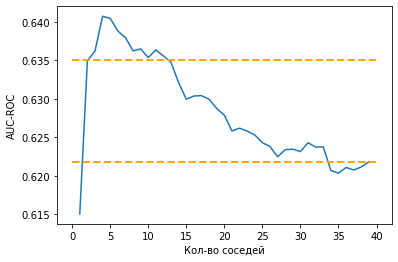

<Figure size 1440x1440 with 0 Axes>

In [9]:
from sklearn.neighbors import KNeighborsClassifier
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
from sklearn.metrics import roc_auc_score

knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 40)}
grid_1 = GridSearchCV(knn, params, cv=5, scoring='roc_auc')
grid_1.fit(X, y)

print("Best k = %.4f" % grid_1.best_params_["n_neighbors"])
print("Best AUC-ROC = %.4f" % grid_1.best_score_)

a1 = np.mean(grid_1.cv_results_["mean_test_score"]) - np.std(grid_1.cv_results_["mean_test_score"])
a2 = np.mean(grid_1.cv_results_["mean_test_score"]) + np.std(grid_1.cv_results_["mean_test_score"])

plt.plot(list(range(1, 40)), grid_1.cv_results_["mean_test_score"])
plt.plot([0, 40], [a1, a1], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.plot([0, 40], [a2, a2], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.xlabel("Кол-во соседей")
plt.ylabel("AUC-ROC")
plt.figure(figsize=(20, 20))

### DecisonTree

Best depth = 7.0000
Best AUC-ROC = 0.8415


<Figure size 1440x1440 with 0 Axes>

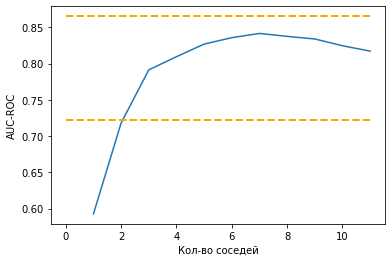

<Figure size 1440x1440 with 0 Axes>

In [10]:
from sklearn.tree import DecisionTreeClassifier

DC = DecisionTreeClassifier()
params_2 = {'max_depth': range(1, 12)}
grid_2 = GridSearchCV(DC, params_2, cv=5, scoring='roc_auc')
grid_2.fit(X, y)

print("Best depth = %.4f" % grid_2.best_params_["max_depth"])
print("Best AUC-ROC = %.4f" % grid_2.best_score_)

b1 = np.mean(grid_2.cv_results_["mean_test_score"]) - np.std(grid_2.cv_results_["mean_test_score"])
b2 = np.mean(grid_2.cv_results_["mean_test_score"]) + np.std(grid_2.cv_results_["mean_test_score"])

plt.plot(list(range(1, 12)), grid_2.cv_results_["mean_test_score"])
plt.plot([0, 11], [b1, b1], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.plot([0, 11], [b2, b2],
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.xlabel("Кол-во соседей")
plt.ylabel("AUC-ROC")
plt.figure(figsize=(20, 20))

### SGD Linear Classifier

Best loss = modified_huber
Best AUC-ROC = 0.6173
Best loss = modified_huber
Best AUC-ROC = 0.6232
Best loss = log
Best AUC-ROC = 0.6173
Best loss = modified_huber
Best AUC-ROC = 0.6283
Best loss = hinge
Best AUC-ROC = 0.6102
Best loss = modified_huber
Best AUC-ROC = 0.6160
Best loss = log
Best AUC-ROC = 0.6192


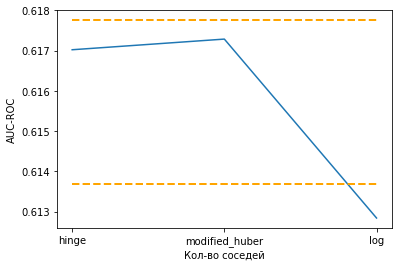

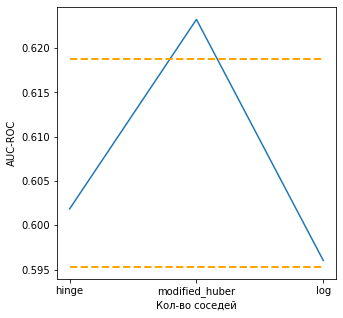

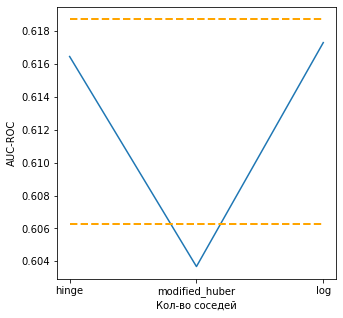

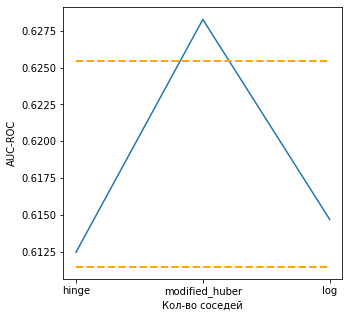

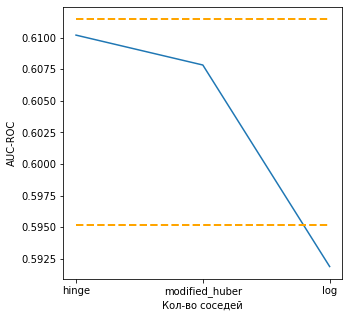

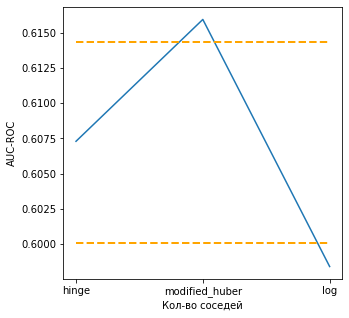

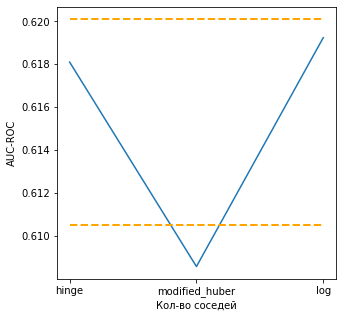

<Figure size 360x360 with 0 Axes>

In [11]:
from sklearn.linear_model import SGDClassifier

SL = SGDClassifier()
params_3 = {'loss': ['hinge', 'modified_huber', 'log']}
for i in range(1, 8):
    grid_3 = GridSearchCV(SL, params_3, cv=5, scoring='roc_auc')
    grid_3.fit(X, y)

    print("Best loss =", grid_3.best_params_["loss"])
    print("Best AUC-ROC = %.4f" % grid_3.best_score_)
    
    c1 = np.mean(grid_3.cv_results_["mean_test_score"]) - np.std(grid_3.cv_results_["mean_test_score"])
    c2 = np.mean(grid_3.cv_results_["mean_test_score"]) + np.std(grid_3.cv_results_["mean_test_score"])

    plt.plot(['hinge', 'modified_huber', 'log'], grid_3.cv_results_["mean_test_score"])
    plt.plot(['hinge', 'log'], [c1, c1],
            linestyle = '--',
            linewidth = 2,
            color = 'orange')
    plt.plot(['hinge', 'log'], [c2, c2],
            linestyle = '--',
            linewidth = 2,
            color = 'orange')
    plt.xlabel("Кол-во соседей")
    plt.ylabel("AUC-ROC")
    plt.figure(figsize=(5, 5))

Что вы можете сказать о получившихся графиках?

##### У knn с учвеличением кол-ва соседей точность уменьшается (начиная с 4). Есть единственный наилучший результат
##### У Решающего дерева тоже имеется единственный наилучший результат
##### SGDC получается веселая ситуация: ответы меняются от раза к разу -> нельзя выявить единственный наилучший гиперпараметр

**Задание 3 (0.5 балла)** Также подберём число деревьев (*n_estimators*) в алгоритме RandomForest. Как известно, в общем случае Random Forest не переобучается с увеличением количества деревьев, так что при увеличении этого гиперпараметра его качество не будет становиться хуже. Поэтому подберите такое количество деревьев, при котором качество на кросс-валидации стабилизируется. Обратите внимание, что для проведения этого эксперимента не нужно с нуля обучать много случайных лесов с различными количествами деревьев. Обучите один случайный лес с максимальным интересным количеством деревьев, а затем рассмотрите подмножества разных размеров, состоящие из деревьев построенного леса (поле [*estimators_*](http://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestClassifier.html)). В дальнейших экспериментах используйте это количество деревьев.

Best n = 71.0000
Best AUC-ROC = 0.8182


Text(0, 0.5, 'AUC-ROC')

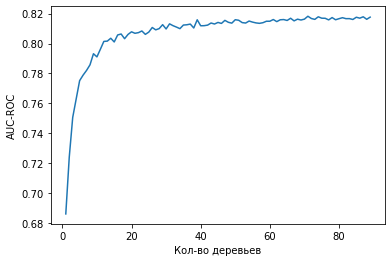

In [12]:
from sklearn.ensemble import RandomForestClassifier
from sklearn.model_selection import cross_validate

RFC = RandomForestClassifier()
params_RFC = {'n_estimators': range(1, 90)}
grid_RFC = GridSearchCV(RFC, params_RFC, cv=5, scoring='roc_auc')
grid_RFC.fit(X, y)

print("Best n = %.4f" % grid_RFC.best_params_["n_estimators"])
print("Best AUC-ROC = %.4f" % grid_RFC.best_score_)

plt.plot(list(range(1, 90)), grid_RFC.cv_results_["mean_test_score"])
plt.xlabel("Кол-во деревьев")
plt.ylabel("AUC-ROC")

In [14]:
grid_RFC.cv_results_["mean_test_score"]

array([0.68612144, 0.72403138, 0.75061937, 0.76291746, 0.77518833,
       0.77887435, 0.78203322, 0.78577797, 0.79318978, 0.79108814,
       0.79618369, 0.80142133, 0.8016132 , 0.8035277 , 0.80105759,
       0.80573291, 0.80637166, 0.80324163, 0.80611105, 0.80784098,
       0.80685099, 0.80728117, 0.80839802, 0.80612962, 0.80765656,
       0.81072056, 0.80915125, 0.80997085, 0.81260435, 0.80974112,
       0.81316343, 0.81193786, 0.81099051, 0.80994845, 0.81235634,
       0.81254118, 0.8130069 , 0.81039875, 0.81587301, 0.81187403,
       0.81193475, 0.81230796, 0.81371309, 0.81305038, 0.81411096,
       0.81344052, 0.81549172, 0.81419776, 0.81362834, 0.81592337,
       0.81554979, 0.81399264, 0.81369831, 0.81503635, 0.81432419,
       0.81378403, 0.81350269, 0.81392617, 0.81489865, 0.81490912,
       0.81605741, 0.81464219, 0.81587177, 0.81602556, 0.81542462,
       0.81690266, 0.81515189, 0.81628801, 0.81572192, 0.81631165,
       0.81824275, 0.81672455, 0.81615148, 0.81787235, 0.81693

##### Сложно выбрать. Пусть кол-во деревьев равно 43 (значение, после которого все последующие результаты отличаются от наилучшего менее, чем на 0.005)

**Задание 4 (0.5 балла)** Подберём число деревьев (*n_estimators*) в алгоритме GradientBoosting. Мы знаем, что ошибка бустинга на тестовых данных, как правило, имеет U-образную форму, то есть сначала уменьшается, а при достижении некоторого числа деревьев начинает расти. Нарисуйте график ошибки в зависимости от числа деревьев. Подберите n_estimators, соответствующий минимуму ошибки.

In [15]:
from sklearn.ensemble import GradientBoostingClassifier

GBC = GradientBoostingClassifier()

Best n = 99
Min Error = 0.1377723328474707


Text(0, 0.5, 'Error')

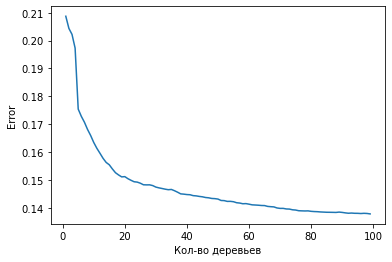

In [17]:
GBC_err = []
err_min = 1

for i in range(1, 100):
    GBC.n_estimators = i
    cv_GBC = cross_validate(GBC,
                     X,
                     y,
                     scoring='roc_auc',
                     cv=5
                    )
    GBC_err.append(1 - cv_GBC['test_score'].mean())
    if 1 - cv_GBC['test_score'].mean() < err_min:
        GBC_best = i
        err_min = 1 - cv_GBC['test_score'].mean()

print("Best n =", GBC_best)
print("Min Error =", err_min)

plt.plot(list(range(1, 100)), GBC_err)
plt.xlabel("Кол-во деревьев")
plt.ylabel("Error")

Best n = 247
Min Error = 0.13419059794363442


Text(0, 0.5, 'AUC-ROC')

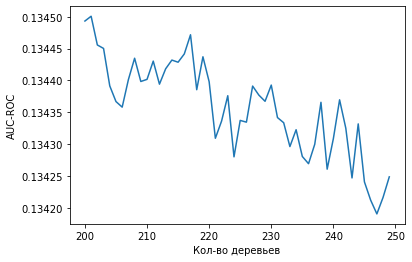

In [145]:
GBC = GradientBoostingClassifier()
GBC_err = []
err_min = 1

for i in range(200, 250):
    GBC.n_estimators = i
    cv_GBC = cross_validate(GBC,
                     X,
                     y,
                     scoring='roc_auc',
                     cv=5
                    )
    GBC_err.append(1 - cv_GBC['test_score'].mean())
    if 1 - cv_GBC['test_score'].mean() < err_min:
        GBC_best = i
        err_min = 1 - cv_GBC['test_score'].mean()

print("Best n =", GBC_best)
print("Min Error =", err_min)

plt.plot(list(range(200, 250)), GBC_err)
plt.xlabel("Кол-во деревьев")
plt.ylabel("Error")

Best n = 289
Min error = 0.13406358621648518


Text(0, 0.5, 'Error')

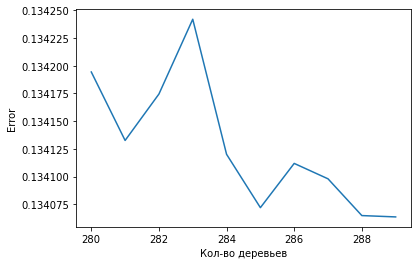

In [357]:
GBC = GradientBoostingClassifier()
params_GB = {'n_estimators': range(280, 290)}
grid_GB = GridSearchCV(GBC, params_GB, cv=5, scoring='roc_auc')
grid_GB.fit(X, y)

print("Best n =", grid_GB.best_params_["n_estimators"])
print("Min error =", 1 - grid_GB.best_score_)

plt.plot(list(range(280, 290)), 1 - grid_GB.cv_results_["mean_test_score"])
plt.xlabel("Кол-во деревьев")
plt.ylabel("Error")

Best n = 298
Min error = 0.13398738652831343


Text(0, 0.5, 'Error')

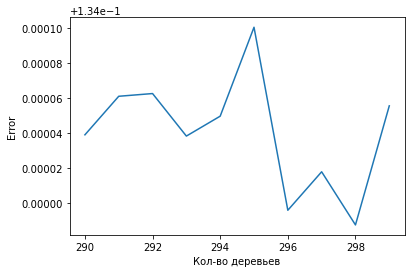

In [18]:
GBC = GradientBoostingClassifier()
params_GB = {'n_estimators': range(290, 300)}
grid_GB = GridSearchCV(GBC, params_GB, cv=5, scoring='roc_auc')
grid_GB.fit(X, y)

print("Best n =", grid_GB.best_params_["n_estimators"])
print("Min error =", 1 - grid_GB.best_score_)

plt.plot(list(range(290, 300)), 1 - grid_GB.cv_results_["mean_test_score"])
plt.xlabel("Кол-во деревьев")
plt.ylabel("Error")

Best n = 300
Min Error = 0.13404033773747293


Text(0, 0.5, 'Error')

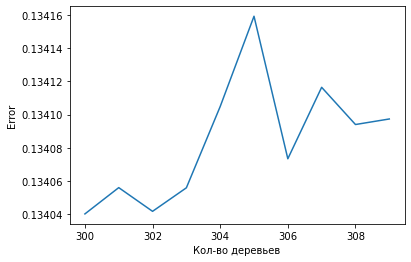

In [349]:
GBC = GradientBoostingClassifier()
GBC_err = []
err_min = 1

for i in range(300, 310):
    GBC.n_estimators = i
    cv_GBC = cross_validate(GBC,
                     X,
                     y,
                     scoring='roc_auc',
                     cv=5
                    )
    GBC_err.append(1 - cv_GBC['test_score'].mean())
    if 1 - cv_GBC['test_score'].mean() < err_min:
        GBC_best = i
        err_min = 1 - cv_GBC['test_score'].mean()

print("Best n =", GBC_best)
print("Min Error =", err_min)

plt.plot(list(range(300, 310)), GBC_err)
plt.xlabel("Кол-во деревьев")
plt.ylabel("Error")

Best n = 310
Min error = 0.13402674957088423


Text(0, 0.5, 'Error')

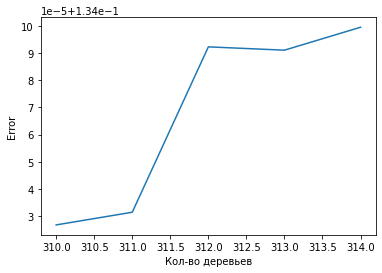

In [19]:
GBC = GradientBoostingClassifier()
params_GB = {'n_estimators': range(310, 315)}
grid_GB = grid_3 = GridSearchCV(GBC, params_GB, cv=5, scoring='roc_auc')
grid_GB.fit(X, y)

print("Best n =", grid_GB.best_params_["n_estimators"])
print("Min error =", 1 - grid_GB.best_score_)

plt.plot(list(range(310, 315)), 1 - grid_GB.cv_results_["mean_test_score"])
plt.xlabel("Кол-во деревьев")
plt.ylabel("Error")

Best n = 320
Min error = 0.13422243167667958


Text(0, 0.5, 'Error')

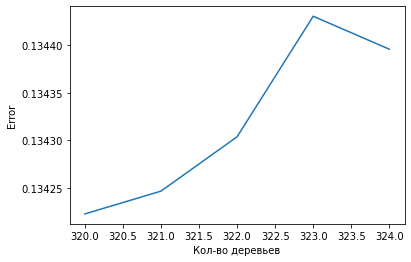

In [20]:
GBC = GradientBoostingClassifier()
params_GB = {'n_estimators': range(320, 325)}
grid_GB = grid_3 = GridSearchCV(GBC, params_GB, cv=5, scoring='roc_auc')
grid_GB.fit(X, y)

print("Best n =", grid_GB.best_params_["n_estimators"])
print("Min error =", 1 - grid_GB.best_score_)

plt.plot(list(range(320, 325)), 1 - grid_GB.cv_results_["mean_test_score"])
plt.xlabel("Кол-во деревьев")
plt.ylabel("Error")

### Мой компьютер не мог справится с задачей комплексно, поэтому пришлось разбивать на отрезки. Ответ: n_estimators = 298

При обучении алгоритмов стоит обращать внимание не только на качество, но и каким образом они работают с данными. В этой задаче получилось так, что некоторые из используемых алгоритмов чувствительны к масштабу признаков. Чтобы убедиться, что это как-то могло повлиять на качество давайте посмотрим на сами признаки.

**Задание 5 (0.5 балла)** Постройте гистограммы для признаков *age*, *fnlwgt*, *capital-gain*. Глядя на получившиеся графики в чем заключается особенность данных? На какие алгоритмы это может повлиять? Может ли масшитабирование повлиять на работу этих алгоритмов?

(array([2466., 2776., 2966., 3066., 1931., 1203.,  667.,  183.,   62.,
          27.]),
 array([17. , 24.3, 31.6, 38.9, 46.2, 53.5, 60.8, 68.1, 75.4, 82.7, 90. ]),
 <BarContainer object of 10 artists>)

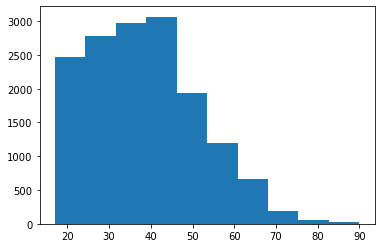

In [21]:
plt.hist(df['age'])

(array([6.681e+03, 6.863e+03, 1.528e+03, 2.150e+02, 4.400e+01, 4.000e+00,
        6.000e+00, 1.000e+00, 2.000e+00, 3.000e+00]),
 array([  19302. ,  165842.3,  312382.6,  458922.9,  605463.2,  752003.5,
         898543.8, 1045084.1, 1191624.4, 1338164.7, 1484705. ]),
 <BarContainer object of 10 artists>)

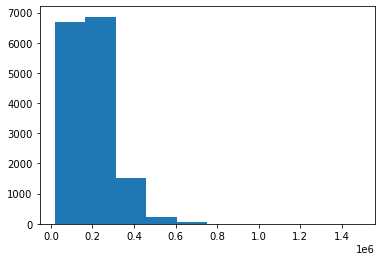

In [22]:
plt.hist(df['fnlwgt'])

(array([1.498e+04, 2.560e+02, 4.300e+01, 2.000e+00, 0.000e+00, 0.000e+00,
        0.000e+00, 0.000e+00, 0.000e+00, 6.600e+01]),
 array([    0. ,  9999.9, 19999.8, 29999.7, 39999.6, 49999.5, 59999.4,
        69999.3, 79999.2, 89999.1, 99999. ]),
 <BarContainer object of 10 artists>)

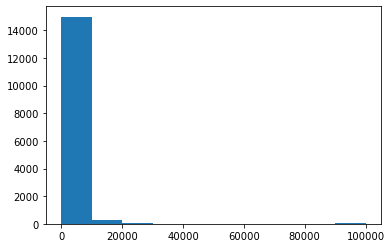

In [23]:
plt.hist(df['capital-gain'])

#### Некоторые данные сильно различаются по масштабу. Особенно значение "age", которое измеряется в десятках и "'fnlwgt", измеряемое в миллионах -> нужно масштабирование. Масштабирование должно положительно повлиять на модели Knn и SGDC. Деревья и бустинг в целом безразличны к масштабу данных.

Масштабирование признаков можно выполнить, например, одним из следующих способов способами:
 - $x_{new} = \dfrac{x - \mu}{\sigma}$, где $\mu, \sigma$ — среднее и стандартное отклонение значения признака по всей выборке (см. функцию [scale](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.scale.html))
 - $x_{new} = \dfrac{x - x_{min}}{x_{max} - x_{min}}$, где $[x_{min}, x_{max}]$ — минимальный интервал значений признака

Похожие схемы масштабирования приведены в классах [StandardScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.StandardScaler.html#sklearn.preprocessing.StandardScaler) и [MinMaxScaler](http://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.MinMaxScaler.html#sklearn.preprocessing.MinMaxScaler).
 
**Задание 6 (1 балл)** Масштабируйте все вещественные признаки одним из указанных способов и подберите оптимальные значения гиперпараметров аналогично пункту выше.

Best k = 39.0000
Best AUC-ROC = 0.8342


<Figure size 1440x1440 with 0 Axes>

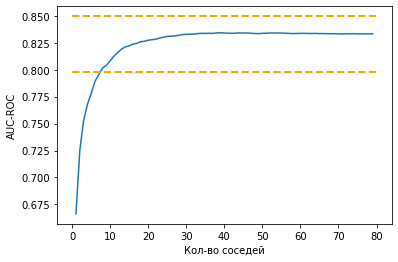

<Figure size 1440x1440 with 0 Axes>

In [16]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

knn = KNeighborsClassifier()
params = {'n_neighbors': range(1, 80)}
grid_4 = GridSearchCV(knn, params, cv=5, scoring='roc_auc')
grid_4.fit(X_sc, y)

print("Best k = %.4f" % grid_4.best_params_["n_neighbors"])
print("Best AUC-ROC = %.4f" % grid_4.best_score_)

a1 = np.mean(grid_4.cv_results_["mean_test_score"]) - np.std(grid_4.cv_results_["mean_test_score"])
a2 = np.mean(grid_4.cv_results_["mean_test_score"]) + np.std(grid_4.cv_results_["mean_test_score"])

plt.plot(list(range(1, 80)), grid_4.cv_results_["mean_test_score"])
plt.plot([0, 80], [a1, a1], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.plot([0, 80], [a2, a2], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.xlabel("Кол-во соседей")
plt.ylabel("AUC-ROC")
plt.figure(figsize=(20, 20))

Best depth = 7.0000
Best AUC-ROC = 0.8415


<Figure size 1440x1440 with 0 Axes>

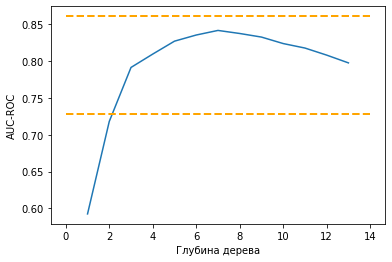

<Figure size 1440x1440 with 0 Axes>

In [17]:
DC = DecisionTreeClassifier()
params_2 = {'max_depth': range(1, 14)}
grid_5 = GridSearchCV(DC, params_2, cv=5, scoring='roc_auc')
grid_5.fit(X_sc, y)

print("Best depth = %.4f" % grid_5.best_params_["max_depth"])
print("Best AUC-ROC = %.4f" % grid_5.best_score_)

b1 = np.mean(grid_5.cv_results_["mean_test_score"]) - np.std(grid_5.cv_results_["mean_test_score"])
b2 = np.mean(grid_5.cv_results_["mean_test_score"]) + np.std(grid_5.cv_results_["mean_test_score"])

plt.plot(list(range(1, 14)), grid_5.cv_results_["mean_test_score"])
plt.plot([0, 14], [b1, b1], 
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.plot([0, 14], [b2, b2],
        linestyle = '--',
        linewidth = 2,
        color = 'orange')
plt.xlabel("Глубина дерева")
plt.ylabel("AUC-ROC")
plt.figure(figsize=(20, 20))

Best loss = log
Best AUC-ROC = 0.8210
Best loss = log
Best AUC-ROC = 0.8205
Best loss = log
Best AUC-ROC = 0.8213
Best loss = log
Best AUC-ROC = 0.8196
Best loss = log
Best AUC-ROC = 0.8194
Best loss = log
Best AUC-ROC = 0.8221
Best loss = log
Best AUC-ROC = 0.8202


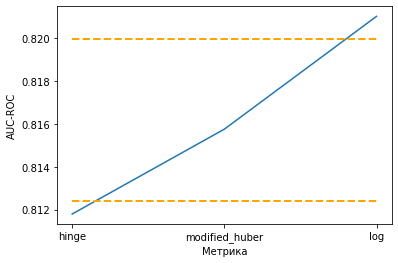

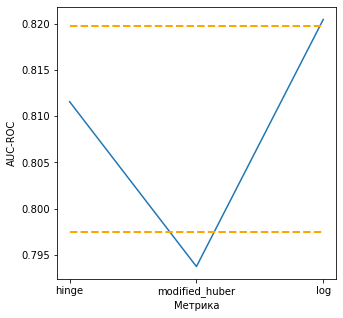

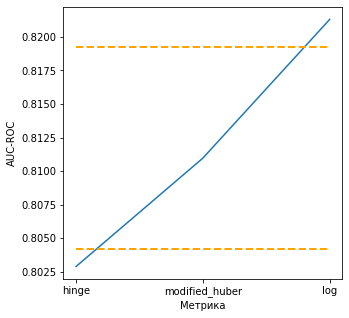

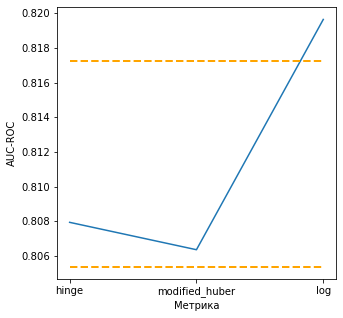

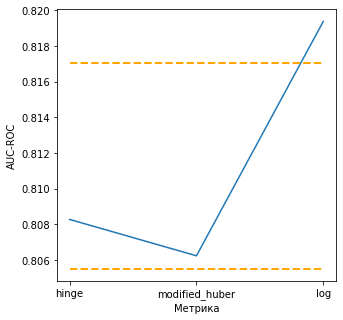

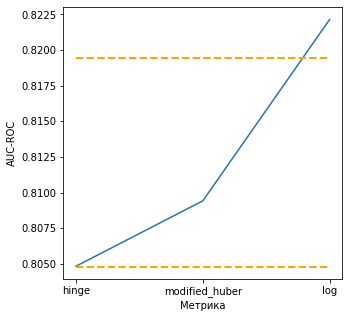

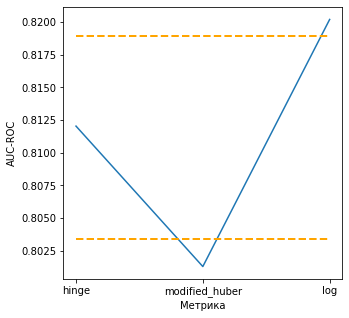

<Figure size 360x360 with 0 Axes>

In [18]:
SL = SGDClassifier()
params_3 = {'loss': ['hinge', 'modified_huber', 'log']}
for i in range(1, 8):
    grid_6 = GridSearchCV(SL, params_3, cv=5, scoring='roc_auc')
    grid_6.fit(X_sc, y)

    print("Best loss =", grid_6.best_params_["loss"])
    print("Best AUC-ROC = %.4f" % grid_6.best_score_)
    
    c1 = np.mean(grid_6.cv_results_["mean_test_score"]) - np.std(grid_6.cv_results_["mean_test_score"])
    c2 = np.mean(grid_6.cv_results_["mean_test_score"]) + np.std(grid_6.cv_results_["mean_test_score"])

    plt.plot(['hinge', 'modified_huber', 'log'], grid_6.cv_results_["mean_test_score"])
    plt.plot(['hinge', 'log'], [c1, c1],
            linestyle = '--',
            linewidth = 2,
            color = 'orange')
    plt.plot(['hinge', 'log'], [c2, c2],
            linestyle = '--',
            linewidth = 2,
            color = 'orange')
    plt.xlabel("Метрика")
    plt.ylabel("AUC-ROC")
    plt.figure(figsize=(5, 5))

Best n = 74.0000
Best AUC-ROC = 0.8181


Text(0, 0.5, 'AUC-ROC')

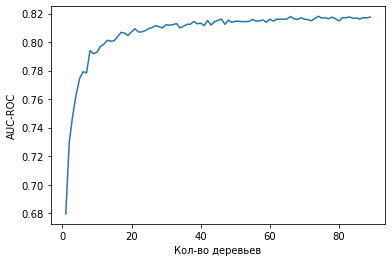

In [27]:
RFC = RandomForestClassifier()
params_RFC = {'n_estimators': range(1, 90)}
grid_RFC = GridSearchCV(RFC, params_RFC, cv=5, scoring='roc_auc')
grid_RFC.fit(X_sc, y)

print("Best n = %.4f" % grid_RFC.best_params_["n_estimators"])
print("Best AUC-ROC = %.4f" % grid_RFC.best_score_)

plt.plot(list(range(1, 90)), grid_RFC.cv_results_["mean_test_score"])
plt.xlabel("Кол-во деревьев")
plt.ylabel("AUC-ROC")

In [28]:
grid_RFC.cv_results_["mean_test_score"]

array([0.67950413, 0.72981848, 0.74850626, 0.76328208, 0.77457235,
       0.77924838, 0.77835817, 0.79403674, 0.79185122, 0.79289375,
       0.79693463, 0.79849112, 0.80129747, 0.80061913, 0.80092308,
       0.80394088, 0.80683215, 0.80630988, 0.80459   , 0.80712862,
       0.80931327, 0.80710095, 0.80715819, 0.80809504, 0.80950465,
       0.81025709, 0.81150497, 0.81077325, 0.81000273, 0.8122033 ,
       0.81185677, 0.81220046, 0.81300934, 0.80990466, 0.81110966,
       0.8123981 , 0.81252299, 0.81446666, 0.81282291, 0.81329993,
       0.81153203, 0.81517655, 0.81192934, 0.81430146, 0.81525786,
       0.8161839 , 0.81240803, 0.81539069, 0.81388271, 0.8145854 ,
       0.81458814, 0.8143841 , 0.81428541, 0.81450489, 0.81584263,
       0.81472391, 0.81486789, 0.81556239, 0.81388793, 0.81607559,
       0.81469526, 0.81612541, 0.81607098, 0.81600467, 0.81623373,
       0.81801101, 0.81632412, 0.81581473, 0.8170653 , 0.81606   ,
       0.81574065, 0.81495603, 0.81656194, 0.81812599, 0.81687

##### Ответ 47 подходит под придуманный мной критерий

In [29]:
GBC = GradientBoostingClassifier()
params_GB = {'n_estimators': range(290, 310)}
grid_GB = GridSearchCV(GBC, params_GB, cv=5, scoring='roc_auc')
grid_GB.fit(X_sc, y)

print("Best n =", grid_GB.best_params_["n_estimators"])
print("Min error =", 1 - grid_GB.best_score_)

Best n = 298
Min error = 0.13395645324443795


Изменилось ли качество у некоторых алгоритмов?
### Knn и SGDC как и предполагалось улучшились, остальные - значимо не изменились

**Задание 7 (1.25 балла)** Теперь сделайте перебор нескольких гиперпараметров по сетке и найдите оптимальные комбинации (лучшее среднее значение качества) для каждого алгоритма в данном случае: 
 - KNN — число соседей (*n_neighbors*) и метрика (*metric*)
 - DecisonTree — глубина дерева (*max_depth*) и критерий разбиения (*criterion*)
 - RandomForest — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - GradientBoosting — критерий разбиения в деревьях (*criterion*) и *max_features* (при фиксированном количестве деревьев, найденном ранее)
 - SGDClassifier — оптимизируемая функция (*loss*) и *penalty*
 
Обратите внимание, что эта операция может быть ресурсо- и трудоемкой. Как оптимизировать подбор параметров по сетке сказано в разделе "Подбор гиперпараметров модели"

In [30]:
knn = KNeighborsClassifier()
params = {'n_neighbors': range(3, 50),
         'metric': ['euclidean', 'manhattan', 'chebyshev', 'minkowski', 'wminkowski', 'seuclidean', 'mahalanobis']}
grid_7 = GridSearchCV(knn, params, cv=5, scoring='roc_auc')
grid_7.fit(X_sc, y)

print("Best k = %.4f" % grid_7.best_params_["n_neighbors"])
print("Best metric =", grid_7.best_params_["metric"])
print("Best AUC-ROC = %.4f" % grid_7.best_score_)

Best k = 41.0000
Best metric = manhattan
Best AUC-ROC = 0.8345


In [31]:
DC = DecisionTreeClassifier()
params_2 = {'max_depth': range(1, 10),
           'criterion': ['gini', 'entropy']}
grid_8 = GridSearchCV(DC, params_2, cv=5, scoring='roc_auc')
grid_8.fit(X_sc, y)

print("Best depth = %.4f" % grid_8.best_params_["max_depth"])
print("Best criterion =", grid_8.best_params_["criterion"])
print("Best AUC-ROC = %.4f" % grid_8.best_score_)

Best depth = 8.0000
Best criterion = entropy
Best AUC-ROC = 0.8420


In [33]:
SL = SGDClassifier()
params_3 = {'loss': ['hinge', 'modified_huber', 'log'],
           'penalty': ['l2', 'l1', 'elasticnet']}
for i in range(1, 8):
    grid_9 = GridSearchCV(SL, params_3, cv=5, scoring='roc_auc')
    grid_9.fit(X_sc, y)

    print("Best loss =", grid_9.best_params_["loss"])
    print("Best penalty =", grid_9.best_params_["penalty"])
    print("Best AUC-ROC = %.4f" % grid_9.best_score_)
    print('------------------------------------------')

Best loss = log
Best penalty = l1
Best AUC-ROC = 0.8197
------------------------------------------
Best loss = log
Best penalty = elasticnet
Best AUC-ROC = 0.8238
------------------------------------------
Best loss = log
Best penalty = l1
Best AUC-ROC = 0.8230
------------------------------------------
Best loss = log
Best penalty = elasticnet
Best AUC-ROC = 0.8213
------------------------------------------
Best loss = log
Best penalty = l1
Best AUC-ROC = 0.8225
------------------------------------------
Best loss = log
Best penalty = l1
Best AUC-ROC = 0.8236
------------------------------------------
Best loss = log
Best penalty = elasticnet
Best AUC-ROC = 0.8214
------------------------------------------


#### Опять-таки разные выводы при каждом запуске -> возьму l1 как самую часто встречающуюся

In [19]:
RFC = RandomForestClassifier(n_estimators = 47)
params_4 = {'criterion': ['gini', 'entropy'],
           'max_features': ['auto', 'sqrt', 'log2']}
grid_10 = GridSearchCV(RFC, params_4, cv=5, scoring='roc_auc')
grid_10.fit(X_sc, y)

print("Best n =", grid_10.best_params_["criterion"])
print("Best n =", grid_10.best_params_["max_features"])
print("Best AUC-ROC = %.4f" % grid_10.best_score_)

Best n = entropy
Best n = auto
Best AUC-ROC = 0.8151


In [169]:
GBC = GradientBoostingClassifier(n_estimators = 10)
params_5 = {'criterion': ['friedman_mse', 'squared_error', 'mse', 'mae'],
           'max_features': ['sqrt', 'log2']}
grid_11 = GridSearchCV(GBC, params_5, cv=5, scoring='roc_auc')
grid_11.fit(X_sc, y)

print("Best criterion =", grid_11.best_params_["criterion"])
print("Best n =", grid_11.best_params_["max_features"])
print("Min Error = ", 1 - grid_11.best_score_)
print('Max AUC-ROC =', grid_11.best_score_)

Best criterion = mse
Best n = sqrt
Min Error =  0.15926607430299222
Max AUC-ROC = 0.8407339256970078


Какой из алгоритмов имеет наилучшее качество? 
### Лучшее качество у дерева и бустинга

**Задание 8 (0.5 балла)** Сравните алгоритмы с точки зрения времени обучения. Обучение какого из алгоритмов работает дольше всего и, как вы думаете, почему?

In [104]:
time_knn = cross_validate(KNeighborsClassifier(n_neighbors=41, metric='manhattan'), X_sc, y, cv=5, scoring='roc_auc')['fit_time'].mean()
time_DC = cross_validate(DecisionTreeClassifier(max_depth=8, criterion='entropy'), X_sc, y, cv=5, scoring='roc_auc')['fit_time'].mean()
time_SL = cross_validate(SGDClassifier(loss='log', penalty='l1'), X_sc, y, cv=5, scoring='roc_auc')['fit_time'].mean()
time_RFC = cross_validate(RandomForestClassifier(n_estimators = 47, criterion='entropy', max_features='sqrt'), X_sc, y, cv=5, scoring='roc_auc')['fit_time'].mean()
time_GBC = cross_validate(GradientBoostingClassifier(n_estimators = 298, criterion='friedman_mse', max_features='sqrt'), X_sc, y, cv=5, scoring='roc_auc')['fit_time'].mean()
print('Время Knn =', time_knn)
print('Время DecisonTree =', time_DC)
print('Время SGDClassifier =', time_SL)
print('Время RandomForestClassifier =', time_RFC)
print('Время GradientBoostingClassifier =', time_GBC)

Время Knn = 0.13771553039550782
Время DecisonTree = 0.027982282638549804
Время SGDClassifier = 0.0459714412689209
Время RandomForestClassifier = 0.7397459506988525
Время GradientBoostingClassifier = 1.3126967906951905


### GradientBoostingClassifier - самый долгий вследствие своей сложности и большого значения гиперпараметра
### DecisionTreeClassifier работает быстрее всех, так как выводит принятие решений на основе простых правил, исходя из характеристик данных.

## Добавление категориальных признаков в модели

Пока мы не использовали нечисловые признаки, которые есть в датасете. Давайте посмотрим, правильно ли мы сделали и увеличится ли качество моделей после добавлениях этих признаков. 

**Задание 9 (0.5 балла)** Преобразуйте все категориальные признаки с помощью метода one-hot-encoding (например, это можно сделать с помощью функции [OneHotEncoder](https://scikit-learn.org/stable/modules/generated/sklearn.preprocessing.OneHotEncoder.html), [pandas.get_dummies](http://pandas.pydata.org/pandas-docs/stable/generated/pandas.get_dummies.html) или [DictVectorizer](http://scikit-learn.org/stable/modules/generated/sklearn.feature_extraction.DictVectorizer.html) из sklearn).

In [25]:
df = pd.read_csv('data.adult.csv')
df = df.replace('?', np.nan)

X = df.drop('>50K,<=50K', axis=1)
cat_cols = df.columns[df.dtypes == object].tolist()
df = pd.get_dummies(df[cat_cols])
X_sc = pd.DataFrame(X_sc)
X = X_sc.join(df)

X

,0,1,2,3,4,5,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,workclass_Private,...,relationship_Wife,race_Amer-Indian-Eskimo,race_Asian-Pac-Islander,race_Black,race_Other,race_White,sex_Female,sex_Male,">50K,<=50K_<=50K",">50K,<=50K_>50K"
0,-0.342919,0.900258,-0.450788,-0.065600,-0.218740,1.588223,0,1,0,0,...,0,0,0,1,0,0,0,1,1,0
1,0.114760,0.010683,-0.059086,-0.150439,-0.218740,-0.074178,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
2,-0.190359,-0.106280,1.116020,-0.150439,-0.218740,-0.074178,0,1,0,0,...,0,0,0,0,0,1,0,1,1,0
3,-1.258276,-0.041382,-0.059086,-0.150439,-0.218740,-0.905379,0,0,0,1,...,0,0,0,0,0,1,1,0,1,0
4,0.648719,-0.371197,1.116020,1.995391,-0.218740,-0.074178,0,0,0,1,...,0,0,0,0,0,1,0,1,0,1
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
15342,-1.029436,3.062953,1.116020,-0.150439,-0.218740,-0.074178,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
15343,-0.495478,0.174179,1.116020,1.995391,-0.218740,0.341422,0,0,0,1,...,1,0,0,0,0,1,1,0,0,1
15344,-0.876877,-0.796853,1.116020,-0.150439,-0.218740,-0.074178,0,0,0,1,...,0,0,0,0,0,1,0,1,1,0
15345,1.564076,0.748381,-0.450788,-0.150439,-0.218740,-0.074178,0,0,0,0,...,0,0,0,0,0,1,0,1,0,1


**Задание 10 (0.5 балла)** Добавьте к масштабированным вещественным признакам закодированные категориальные и обучите алгоритмы с наилучшими гиперпараметрами из предыдущего пункта. Дало ли добавление новых признаков прирост качества? Измеряйте качество как и раньше используя 5-Fold CV. Для этого удобно воспользоваться функцией [cross_val_score](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.cross_val_score.html).

In [26]:
from sklearn.model_selection import cross_val_score

knn = KNeighborsClassifier(n_neighbors=41, metric='manhattan')
 
print(cross_val_score(knn, X, y, cv=5, scoring='roc_auc').mean())

0.7942919453188791


In [27]:
DC = DecisionTreeClassifier(max_depth=8, criterion='entropy')

print(cross_val_score(DC, X, y, cv=5, scoring='roc_auc').mean())

0.8392520027843389


In [28]:
SL = SGDClassifier(loss='log', penalty='l1')

print(cross_val_score(SL, X, y, cv=5, scoring='roc_auc').mean())

0.8177293636003254


In [29]:
RFC = RandomForestClassifier(n_estimators = 47, criterion='entropy', max_features='sqrt')

print(cross_val_score(RFC, X, y, cv=5, scoring='roc_auc').mean())

0.8289190473952072


In [170]:
GBC = GradientBoostingClassifier(n_estimators = 298, criterion='mse', max_features='auto')

print(cross_val_score(GBC, X, y, cv=5, scoring='roc_auc').mean())

0.8653176329594897


Отличается ли теперь наилучший классификатор от наилучшего в предыдущем пункте?
### Теперь бустинг сильно вырвался вперед

## Поиск новых полезных признаков

**Задание 11 (1.25 балла).** Попробуем улучшить качество модели, добавив в неё новые информативные признаки. Поступим так же, как действовали на [семинаре](https://github.com/Murcha1990/ML_Econom_2021-2022/blob/main/Семинары/Семинар%207/Seminar7.ipynb):
* добавьте к модели полиномиальных признаков степени 2 (для создания полиномиальных признаков используйте только исходные числовые признаки)
* затем снизьте размерность с помощью:
a) фильтрационных методов
b) жадного отбора признаков (RFE)
с) встроенного в модель метода отбора признаков.

Для каждого пункта выше выберите один метод и подберите для него оптимальные гиперпараметры, а также количество финальных признаков (по кросс-валидации).

* Затем можно добавить к модели закодированные в предыдущем пункте категориальные признаки.

Позволил ли этот подход улучшить качество моделей? 

In [34]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import PolynomialFeatures, StandardScaler

df = pd.read_csv('data.adult.csv')
df = df.replace('?', np.nan)
df = df.dropna()
X = df.drop('>50K,<=50K', axis=1)
num_cols = X.columns[X.dtypes != object].tolist()
X = X[num_cols]
X.isnull().sum()

age               0
fnlwgt            0
education-num     0
capital-gain      0
capital-loss      0
hours-per-week    0
dtype: int64

In [43]:
pipi_1 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', KNeighborsClassifier(n_neighbors=41, metric='manhattan'))]
)
print(cross_val_score(pipi_1, X, y, cv=5, scoring='roc_auc').mean())

0.8349798426405515


In [36]:
pipi_2 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', DecisionTreeClassifier(max_depth=8, criterion='entropy'))]
)
print(cross_val_score(pipi_2, X, y, cv=5, scoring='roc_auc').mean())

0.8316575304240793


In [37]:
pipi_3 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', SGDClassifier(loss='log', penalty='l1'))]
)
print(cross_val_score(pipi_3, X, y, cv=5, scoring='roc_auc').mean())

0.8338796575883247


In [38]:
pipi_4 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', RandomForestClassifier(n_estimators = 47, criterion='entropy', max_features='sqrt'))]
)
print(cross_val_score(pipi_4, X, y, cv=5, scoring='roc_auc').mean())

0.8173055704679058


In [39]:
pipi_5 = Pipeline([
    ('poly_featurizer_', PolynomialFeatures(degree=2)),
    ('scaler_', StandardScaler()),
    ('model_', GradientBoostingClassifier(n_estimators = 298, criterion='mse', max_features='auto'))]
)
print(cross_val_score(pipi_5, X, y, cv=5, scoring='roc_auc').mean())

0.861353801809908


### а) Фильтрационные методы

In [53]:
X.shape

(15347, 6)

In [54]:
X_tr = pipi_1[:-1].fit_transform(X, y)

In [55]:
X_tr.shape

(15347, 28)

In [61]:
from sklearn.pipeline import make_pipeline
from sklearn.feature_selection import f_classif, chi2, mutual_info_classif
from sklearn.feature_selection import SelectKBest

for i in range(1, 27):
    sel = SelectKBest(score_func=mutual_info_classif, k=i)
    clf = KNeighborsClassifier(n_neighbors=41, metric='manhattan')
    pipi_12 = make_pipeline(sel, clf)
    cv_res1 = cross_validate(pipi_12, X_tr, y, cv=5, scoring='roc_auc')
    print('Для k =', i)
    print(cv_res1['test_score'].mean())

Для k = 1
0.7702767375198734
Для k = 2
0.8010394148997051
Для k = 3
0.8081200968489911
Для k = 4
0.8170409210600207
Для k = 5
0.8272790491606669
Для k = 6
0.8300392278362295
Для k = 7
0.8299870161197926
Для k = 8
0.8310045593739291
Для k = 9
0.8308674719731041
Для k = 10
0.8319086432045953
Для k = 11
0.8300361786599361
Для k = 12
0.8303465917743909
Для k = 13
0.8305269473742165
Для k = 14
0.8304773412164552
Для k = 15
0.8313851753420918
Для k = 16
0.8375485265159398
Для k = 17
0.8379000897234917
Для k = 18
0.8381662606842191
Для k = 19
0.8392106106958319
Для k = 20
0.8395295030115257
Для k = 21
0.8394674752435283
Для k = 22
0.8382184728394952
Для k = 23
0.8371583537526327
Для k = 24
0.8360587608163147
Для k = 25
0.8353090833684513
Для k = 26
0.835023221865856


### Лучшее значение при k=20. И в данном случае отбор сильно улучшил качество!

In [84]:
for i in range(1, 27):
    sel_2 = SelectKBest(score_func=f_classif, k=i)
    clf_2 =  DecisionTreeClassifier(max_depth=8, criterion='entropy')
    pipi_22 = make_pipeline(sel_2, clf_2)
    cv_res1 = cross_validate(pipi_22, X_tr, y, cv=5, scoring='roc_auc')
    print('Для k =', i)
    print(cv_res1['test_score'].mean())

Для k = 1
0.7698793357349173
Для k = 2
0.7893736723518916
Для k = 3
0.7895151538734761
Для k = 4
0.7899807606237833
Для k = 5
0.7917632751869969
Для k = 6
0.7906322709734525
Для k = 7
0.7897770861356422
Для k = 8
0.8283232552086595
Для k = 9
0.8270872502449634
Для k = 10
0.8283039561356909
Для k = 11
0.8275548616612542
Для k = 12
0.8275407393055236
Для k = 13
0.8270996356509702
Для k = 14
0.8255559096071868
Для k = 15
0.8338563540106193
Для k = 16
0.8326726722285036
Для k = 17
0.8348606501005642
Для k = 18
0.8349531753364043
Для k = 19
0.8377515582997701
Для k = 20
0.8340126631268238
Для k = 21
0.8333888064941843
Для k = 22
0.8338066694225506
Для k = 23
0.8318953189753733
Для k = 24
0.8304449192195333
Для k = 25
0.8314557189056373
Для k = 26
0.8309607699071622


#### Лучший результат при k = 19. Но качество не улучшилось

In [168]:
best_res = 0

for i in range(1, 27):
    sel_5 = SelectKBest(score_func=f_classif, k=i)
    clf_5 = GradientBoostingClassifier(n_estimators = 298, criterion='mse', max_features='auto')
    pipi_52 = make_pipeline(sel_5, clf_5)
    cv_res5 = cross_validate(pipi_52, X_tr, y, cv=5, scoring='roc_auc')
    if cv_res5['test_score'].mean() > best_res:
        best_res = cv_res5['test_score'].mean()
        best_i = i
print('Лучший результат при k =', best_i)
print(best_res)

Лучший результат при k = 18
0.865588449300768


#### Качество улучшилось!

### b) Жадный отбор признаков

In [67]:
from sklearn.feature_selection import RFE
from sklearn.linear_model import LogisticRegression
best_res = 0

for i in range(2, 26):
    for j in range(2, 25, 4):
        sel_3 = RFE(LogisticRegression(max_iter=1000), n_features_to_select = i, step = j)
        clf_3 =  SGDClassifier(loss='log', penalty='l1')
        pipi_32 = make_pipeline(sel_3, clf_3)
        cv_res3 = cross_validate(pipi_32, X_tr, y, cv=5, scoring='roc_auc')
        if cv_res3['test_score'].mean() > best_res:
            best_res = cv_res3['test_score'].mean()
            best_i = i
            best_j = j
print('Лучший k =', best_i, 'при выбрасывании', best_j, 'признаков')
print(best_res)

Лучший k = 14 при выбрасывании 22 признаков
0.8397741163892345


#### Качество улучшилось!

### c) Встроенные методы отбора

In [91]:
from sklearn.feature_selection import SelectFromModel

best_res = 0
for i in np.linspace(0.0001, 20, 100):
    sel_4 = SelectFromModel(LogisticRegression(penalty='l1', max_iter=1000, solver='liblinear'), threshold=i)
    clf_4 = RandomForestClassifier(n_estimators = 47, criterion='entropy', max_features='sqrt')
    pipi_42 = make_pipeline(sel_4, clf_4)
    cv_res4 = cross_validate(pipi_42, X_tr, y, cv=5, scoring='roc_auc')
    if cv_res4['test_score'].mean() > best_res:
        best_res = cv_res4['test_score'].mean()
        best_i = i
print('Лучший результат при отборе признаков с весами больше', best_i)
print(best_res)

Лучший результат при отборе признаков с весами больше 0.0001
0.8146792955126765


### Выводы:
#### У некоторых моделей качество улучшилось (У Бустинга, SGDClassifier и Knn)

## Смешивание моделей

Во всех предыдущих пунктах мы получили много сильных моделей, которые могут быть достаточно разными по своей природе (например, метод ближайших соседей и случайный лес). Часто на практике оказывается возможным увеличить качество предсказания путем смешивания подобных разных моделей. Давайте посмотрим, действительно ли это дает прирост в качестве.

Выберите из построенных моделей двух предыдущих пунктов две, которые дали наибольшее начество на кросс-валидации (обозначим их $clf_1$ и $clf_2$). Далее постройте новый классификатор, ответ которого на некотором объекте $x$ будет выглядеть следующим образом:

$$result(x) = clf_1(x) \cdot \alpha + clf_2(x) \cdot (1 - \alpha)$$

где $\alpha$ — гиперпараметр нового классификатора.

**Задание 12 (1 балл)** Подберите по сетке от 0 до 1 $\alpha$ для этого классификатора с помощью 5-Fold CV и постройте график качества в зависимости от $\alpha$ (аналогичный графику в разделе "Обучение классификаторов и оценка качества"). Дал ли этот подход прирост к качеству по сравнению с моделями ранее?

Наилучший результат при alpha= 1.0
AUC-ROC = 0.6958342746044014


<Figure size 1440x1440 with 0 Axes>

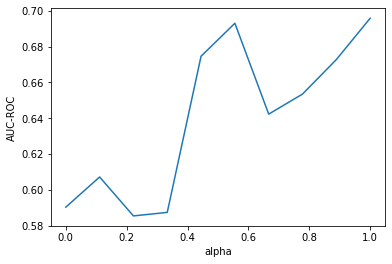

<Figure size 1440x1440 with 0 Axes>

In [152]:
from sklearn.model_selection import train_test_split
from sklearn.metrics import roc_auc_score
from sklearn.model_selection import KFold

df = pd.read_csv('data.adult.csv')
df = df.replace('?', np.nan)
df = df.dropna()
X = df.drop('>50K,<=50K', axis=1)
num_cols = X.columns[X.dtypes != object].tolist()
X = X[num_cols]


kf = KFold(n_splits=5)
best_AUC = 0.6
result = []

for a in np.linspace(0.00000001, 1, 10):
    ras = []
    for train_index, test_index in kf.split(X):
        X_train = pd.DataFrame(np.ones((len(train_index), 6)))
        X_test = pd.DataFrame(np.ones((len(test_index), 6)))
        y_train = pd.DataFrame(np.ones(len(train_index)))
        y_test = pd.DataFrame(np.ones(len(test_index)))
        for i in range(0, len(train_index)):
            for j in range(0, 6):
                X_train.iloc[i, j] = X.iloc[train_index[i], j]
                y_train.iloc[i] = y.iloc[train_index[i]]
        for i in range(0, len(test_index)):
            for j in range(0, 6):
                X_test.iloc[i, j] = X.iloc[test_index[i], j]
                y_test.iloc[i] = y.iloc[test_index[i]]
        res = pd.DataFrame(list(range(0, len(y_test))))
        GBC = GradientBoostingClassifier(n_estimators = 298, criterion='mse', max_features='auto')
        SGD = SGDClassifier(loss='log', penalty='l1')
        GBC.fit(X_train, y_train)
        SGD.fit(X_train, y_train)
        c1 = GBC.predict_proba(X_test)
        c2 = SGD.predict_proba(X_test)
        for i in range(0, len(y_test)):
            if a * c1[i][1] + (1 - a) * c2[i][1] > 0.6:
                res.iloc[i, 0] = 1
            else:
                res.iloc[i, 0] = 0
        ras.append(roc_auc_score(y_test, res))
    result.append(np.mean(ras))
    if np.mean(ras) > best_AUC:
        best_a = a
        best_AUC = np.mean(ras)
    
print('Наилучший результат при alpha=', best_a)
print('AUC-ROC =', best_AUC)
plt.plot(list(np.linspace(0, 1, 10)), result)
plt.xlabel("alpha")
plt.ylabel("AUC-ROC")
plt.figure(figsize=(20, 20))

#### Бустинг слишком силен, поэтому отнимает себе всё значение альфы. Но мне не нравится результат, поэтому попробуем с другими алгоритмами

Наилучший результат при alpha= 0.5555555600000001
AUC-ROC = 0.7037522478751298


<Figure size 1440x1440 with 0 Axes>

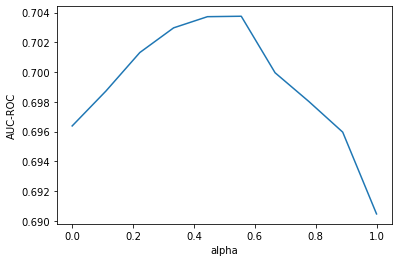

<Figure size 1440x1440 with 0 Axes>

In [158]:
df = pd.read_csv('data.adult.csv')
df = df.replace('?', np.nan)
df = df.dropna()
X = df.drop('>50K,<=50K', axis=1)
num_cols = X.columns[X.dtypes != object].tolist()
X = X[num_cols]
scaler = StandardScaler()
X = scaler.fit_transform(X)
X = pd.DataFrame(X)

kf = KFold(n_splits=5)
best_AUC = 0.6
result_2 = []

for a in np.linspace(0.00000001, 1, 10):
    ras = []
    for train_index, test_index in kf.split(X):
        X_train = pd.DataFrame(np.ones((len(train_index), 6)))
        X_test = pd.DataFrame(np.ones((len(test_index), 6)))
        y_train = pd.DataFrame(np.ones(len(train_index)))
        y_test = pd.DataFrame(np.ones(len(test_index)))
        for i in range(0, len(train_index)):
            for j in range(0, 6):
                X_train.iloc[i, j] = X.iloc[train_index[i], j]
                y_train.iloc[i] = y.iloc[train_index[i]]
        for i in range(0, len(test_index)):
            for j in range(0, 6):
                X_test.iloc[i, j] = X.iloc[test_index[i], j]
                y_test.iloc[i] = y.iloc[test_index[i]]
        res = pd.DataFrame(list(range(0, len(y_test))))
        KNN = KNeighborsClassifier(n_neighbors=41, metric='manhattan')
        DCC = DecisionTreeClassifier(max_depth=8, criterion='entropy')
        KNN.fit(X_train, y_train)
        DCC.fit(X_train, y_train)
        c1 = KNN.predict_proba(X_test)
        c2 = DCC.predict_proba(X_test)
        for i in range(0, len(y_test)):
            if a * c1[i][1] + (1 - a) * c2[i][1] > 0.5:
                res.iloc[i, 0] = 1
            else:
                res.iloc[i, 0] = 0
        ras.append(roc_auc_score(y_test, res))
    result_2.append(np.mean(ras))
    if np.mean(ras) > best_AUC:
        best_a = a
        best_AUC = np.mean(ras)
    
print('Наилучший результат при alpha=', best_a)
print('AUC-ROC =', best_AUC)
plt.plot(list(np.linspace(0, 1, 10)), result_2)
plt.xlabel("alpha")
plt.ylabel("AUC-ROC")
plt.figure(figsize=(20, 20))

##### Результаты ухудшились, но возможно я криво написал код. Попробую другой метод, который основан на решении с форума.

Лучший результат при alpha= 0.5789474105263158
AUC-ROC = 0.840742923681485


Text(0, 0.5, 'AUC-ROC')

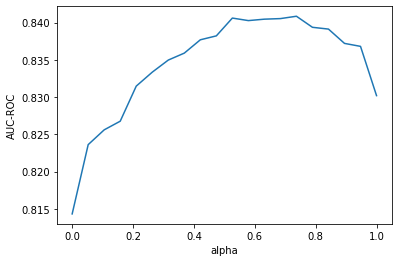

In [166]:
from sklearn.ensemble import VotingClassifier

y=y.astype('float')
X=X.astype('float')
X = X.fillna(0)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.2)
best_auc = 0
res=[]
for a in np.linspace(0.0000001,1,20):
    DCC = DecisionTreeClassifier(max_depth = 8, criterion='entropy')
    SGD = SGDClassifier(loss='log', penalty='l1')

    ensemble = VotingClassifier(estimators = [('clf1', DCC), ('clf2', SGD)], voting='soft', weights = [a, 1-a])
    res.append(cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc').mean())
    if cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc').mean() > best_auc:
        best_a = a
        best_auc = cross_val_score(ensemble, X_train, y_train, cv=5, scoring='roc_auc').mean()
print('Лучший результат при alpha=', best_a)
print('AUC-ROC =', best_auc)
plt.plot(list(np.linspace(0, 1, 20)), res)
plt.xlabel("alpha")
plt.ylabel("AUC-ROC")

#### Лучше не стало (ну по сравнению с предыдущим смешиванием стало, но не лучше чем у других моделей было раньше)

## Сравнение построенных моделей

![](http://cdn.shopify.com/s/files/1/0870/1066/files/compare_e8b89647-3cb6-4871-a976-2e36e5987773.png?1750043340268621065)

После того как было построено много моделей хотелось бы сравнить их между собой. Для этого можно построить "ящик с усами" (диаграму размаха). Для этого можно воспользоваться библиотекой [matplotlib](https://matplotlib.org/3.1.0/api/_as_gen/matplotlib.pyplot.boxplot.html) или [seaborn](https://seaborn.pydata.org/generated/seaborn.boxplot.html).

**Задание 13 (1 балл)** Для каждого типа классификатора (kNN, DecisionTree, RandomForest, SGD classifier), а так же смешанной модели выберите тот, которых давал наилучшее качество на кросс-валидации (с учетом подобранных гиперпараметров) и постройте диаграмму размаха (все классификаторы должны быть изображены на одном графике).
 
Сделайте общие итоговые выводы о классификаторах с точки зрения их работы с признаками и сложности самой модели (какие гиперпараметры есть у модели, сильно ли изменение значения гиперпараметра влияет на качество модели).

Text(0, 0.5, 'AUC-ROC')

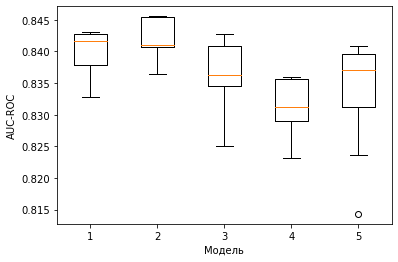

In [167]:
df = pd.read_csv('data.adult.csv')
df = df.replace('?', np.nan)
df = df.dropna()
X = df.drop('>50K,<=50K', axis=1)
num_cols = X.columns[X.dtypes != object].tolist()
X = X[num_cols]

sel = SelectKBest(score_func=mutual_info_classif, k=20)
clf_1 = KNeighborsClassifier(n_neighbors=41, metric='manhattan')
pipi_13 = make_pipeline(sel, clf)
cv_res_knn = cross_validate(pipi_13, X_tr, y, cv=5, scoring='roc_auc')

scaler = StandardScaler()
X_sc = scaler.fit_transform(X)

pipi_23 = DecisionTreeClassifier(max_depth=8, criterion='entropy')
cv_res_DC = cross_validate(pipi_23, X_sc, y, cv=5, scoring='roc_auc')

sel_3 = RFE(LogisticRegression(max_iter=1000), n_features_to_select = 14, step = 22)
clf_3 =  SGDClassifier(loss='log', penalty='l1')
pipi_33 = make_pipeline(sel_3, clf_3)
cv_res_SGD = cross_validate(pipi_33, X_tr, y, cv=5, scoring='roc_auc')

df = pd.read_csv('data.adult.csv')
df = df.replace('?', np.nan)
X = df.drop('>50K,<=50K', axis=1)
cat_cols = df.columns[df.dtypes == object].tolist()
df = pd.get_dummies(df[cat_cols])
X_sc = pd.DataFrame(X_sc)
X = X_sc.join(df)

RFC = RandomForestClassifier(n_estimators = 47, criterion='entropy', max_features='sqrt')
cv_res_RFC = cross_validate(RFC, X, y, cv=5, scoring='roc_auc')



data = [cv_res_knn['test_score'], cv_res_DC['test_score'], cv_res_SGD['test_score'], cv_res_RFC['test_score'], res]
plt.boxplot(data)
plt.xlabel("Модель")
plt.ylabel("AUC-ROC")

### Из всех рассмотренных моделей лучший результат показывает DecisionTree
#### У этой модели наибольшее значение обоих квантилей, а также максимальное и минимальное значение
### Лучшее значение медианы у Knn

### Knn изначально работал плохо. Масштабирование и отбор признаков сильно улучшили его результаты. Но точность всё же не самая высокая и в некоторых задачах долго обучался. Важно правильно подобрать гиперпараметр.
### DecisionTree показывали себя одним лучших классификаторов: очень быстро обучаются, им практически всё равно на масштабирование и отбор некоторых других признаков. Результат - второе место после Бустинга. Важно подбирать оптимальный гиперпараметр (глубину), но это делается быстро
### SGDClassifier изначально тоже работал не очень хорошо, потом возникли проблемы с гиперпараметрами (значит при их изменении качество не сильно менялось и каждый раз какой-то из гиперпараметров показывал чуть лучший результат). После масштабирования и отбора признаков результаты сильно улучшились
### СлучайныйЛес, возможно, у меня как-то полетел или изначально был выбран неудачный гиперпараметр... Но он сработал очень плохо. Худший результат
### Бустинг. Долгий. Очень долгий. Но самые лучшие результаты - всё справедливо. Оптимальный гиперпараметр важен, но достаточно найти его в некотором приближении (если б я взял 200, а не 298 результат изменился бы несильно, а время может быть отлично бы сократилось)

In [1]:
?GradientBoosting

Object `GradientBoosting` not found.
